In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split


import warnings
warnings.filterwarnings("ignore")
sns.set_style()

In [3]:
dados = pd.read_csv(r'D:\Blue EdTech\Bootcamp\dados\full_grouped.csv')
df = dados[dados['Country/Region'].isin(['Mexico', 'Argentina', 
                                        'Ecuador', 'Chile', 'Spain'])]

df['Date'] = pd.to_datetime(df.Date, format="%Y-%m-%d")

In [30]:
df

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
6,2020-01-22,Argentina,0,0,0,0,0,0,0,Americas
35,2020-01-22,Chile,0,0,0,0,0,0,0,Americas
51,2020-01-22,Ecuador,0,0,0,0,0,0,0,Americas
111,2020-01-22,Mexico,0,0,0,0,0,0,0,Americas
157,2020-01-22,Spain,0,0,0,0,0,0,0,Europe
...,...,...,...,...,...,...,...,...,...,...
34975,2020-07-27,Argentina,167416,3059,72575,91782,4890,120,2057,Americas
35004,2020-07-27,Chile,347923,9187,319954,18782,2133,75,1859,Americas
35020,2020-07-27,Ecuador,81161,5532,34896,40733,467,17,0,Americas
35080,2020-07-27,Mexico,395489,44022,303810,47657,4973,342,8588,Americas


## Estacionariedade e Dickey Fuller

### Funções

#### criar_serie
* com confirmados e obitos
* a coluna de data como index

In [4]:
def criar_serie(df, nome_pais):

    filtro = df[df['Country/Region'] == nome_pais]
    pais = filtro[['Date', 'Confirmed', 'Deaths']]
    
    pd.to_datetime(pais.Date)
    pais.set_index('Date', inplace=True)
    
    return pais


argentina = criar_serie(df, 'Argentina')
chile = criar_serie(df, 'Chile')
equador = criar_serie(df, 'Ecuador')
mexico = criar_serie(df, 'Mexico')
espanha = criar_serie(df, 'Spain')

full_serie = criar_serie(df, df['Country/Region'])

#### media_movel

In [5]:
def media_movel(serie, periodo):
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 5), constrained_layout=True)

    # Valores originais
    ax = axs[0]
    mm = serie.Confirmed.resample(periodo).mean() # O periodo da media movel pode ser um numero inteiro seguido de D, W, M, Y ou apenas as iniciais
    ax.set_title(r'Valor original e média movel de Confirmados')
    ax.plot(serie.Confirmed, color='blue', label='Original')
    ax.plot(mm, color='red', label='Média movel')
    ax.legend(loc='best')

    # Media movel
    ax = axs[1]
    mm = serie.Deaths.resample(periodo).mean()
    ax.set_title(r'Valor original e média movel de Obitos')
    ax.plot(serie.Deaths, color='blue', label='Original')
    ax.plot(mm, color='red', label='Média movel')
    ax.legend(loc='best')


    return plt.show

### Analise de tendencia

O '.resample(periodo).mean()' na função media_movel irá retornar a media movel, fazendo com que seja possivel observar o grafico da serie sem os ruidos, facilitando a analise de tendencia dos dados.

Para entender melhor como funciona a media movel, suposmos que será utilizado o periodo de 15 dias para o salto da janela de observação, os primeiro 14 dias serão pulados, e apenas o dia 15 será observado, apartir desse dia, a media do dia posterior será calculada baseada na media dos 15 dias anteriores e o processo será repetido até o fim da serie.

<function matplotlib.pyplot.show(close=None, block=None)>

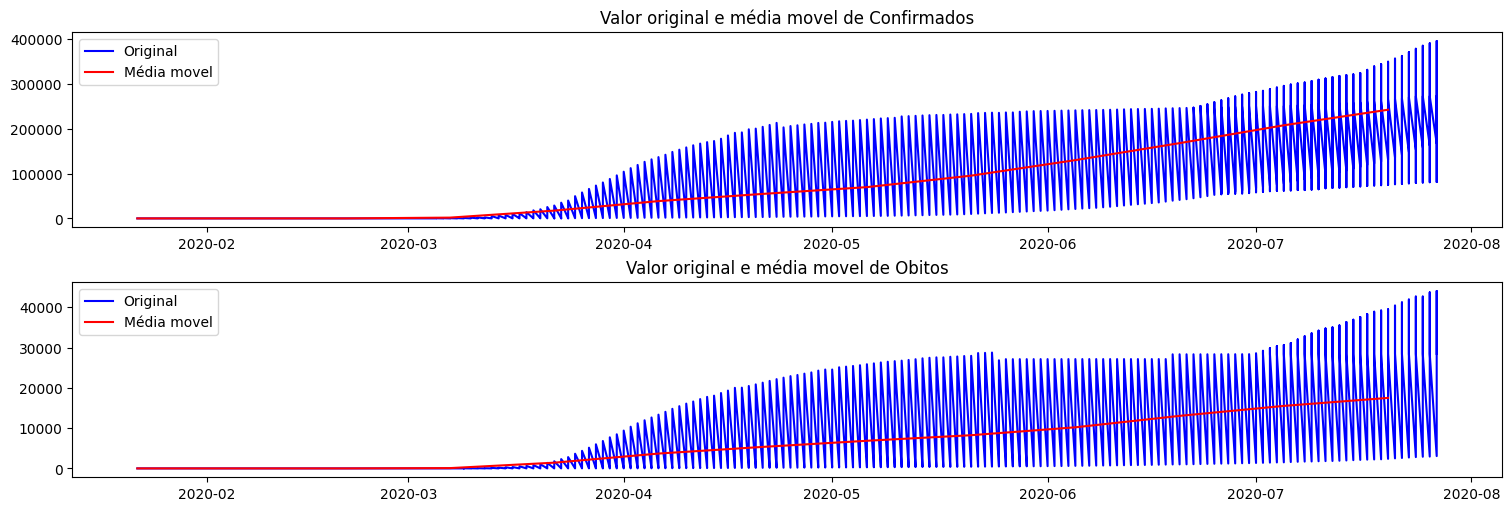

In [6]:
media_movel(full_serie, periodo='15D')

### Analise de sazionalidade

diff() ou diferença sucessiva, defini quantas diferenças será utilizado, por padrão o periodo é 1. (pesquisar sobre diferença sucessiva)

<AxesSubplot: xlabel='Date'>

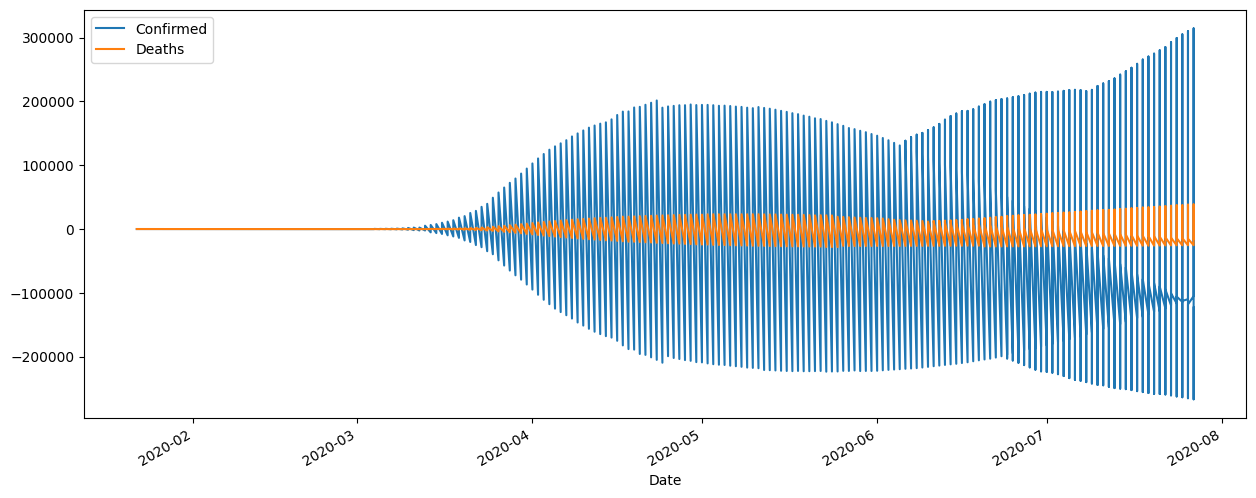

In [7]:
full_serie.diff().plot(figsize=(15,6)) 

<AxesSubplot: xlabel='Date'>

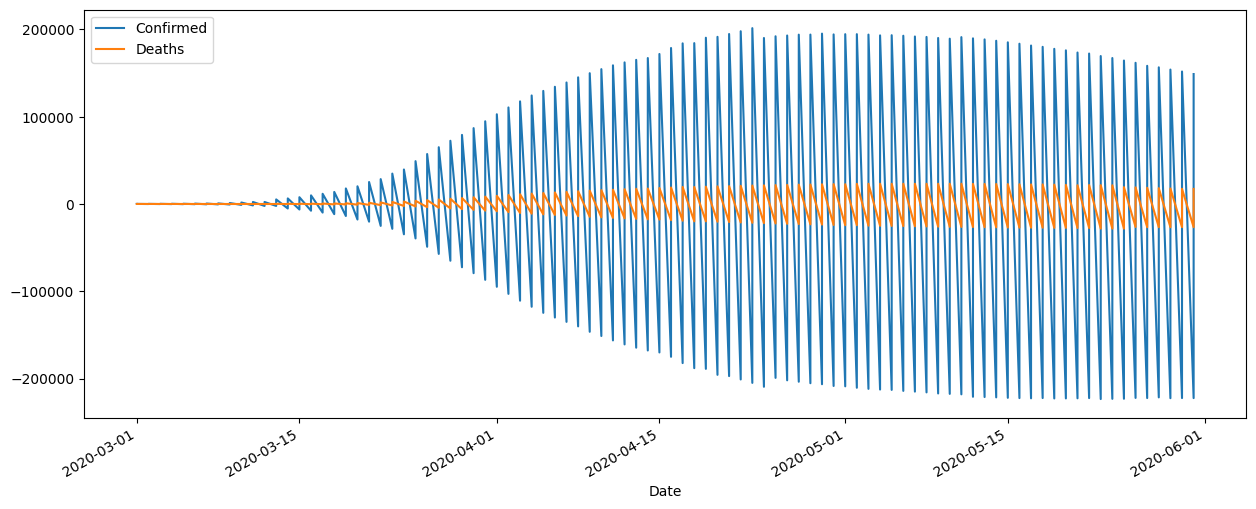

In [8]:
# criando filtros para analiser melhor o grafico
filtro = (full_serie.index.month >= 3) & (full_serie.index.month <=5)
full_serie[filtro].diff().plot(figsize=(15,6))

### Analisando ADF e Testando modelo SARIMAX

ADF Statistic: 1.0198679084570061
p-value: 0.9944712170177812
                                       SARIMAX Results                                        
Dep. Variable:                              Confirmed   No. Observations:                  188
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1643.025
Date:                                Tue, 10 Jan 2023   AIC                           3310.050
Time:                                        18:41:53   BIC                           3348.824
Sample:                                    01-22-2020   HQIC                          3325.761
                                         - 07-27-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.597

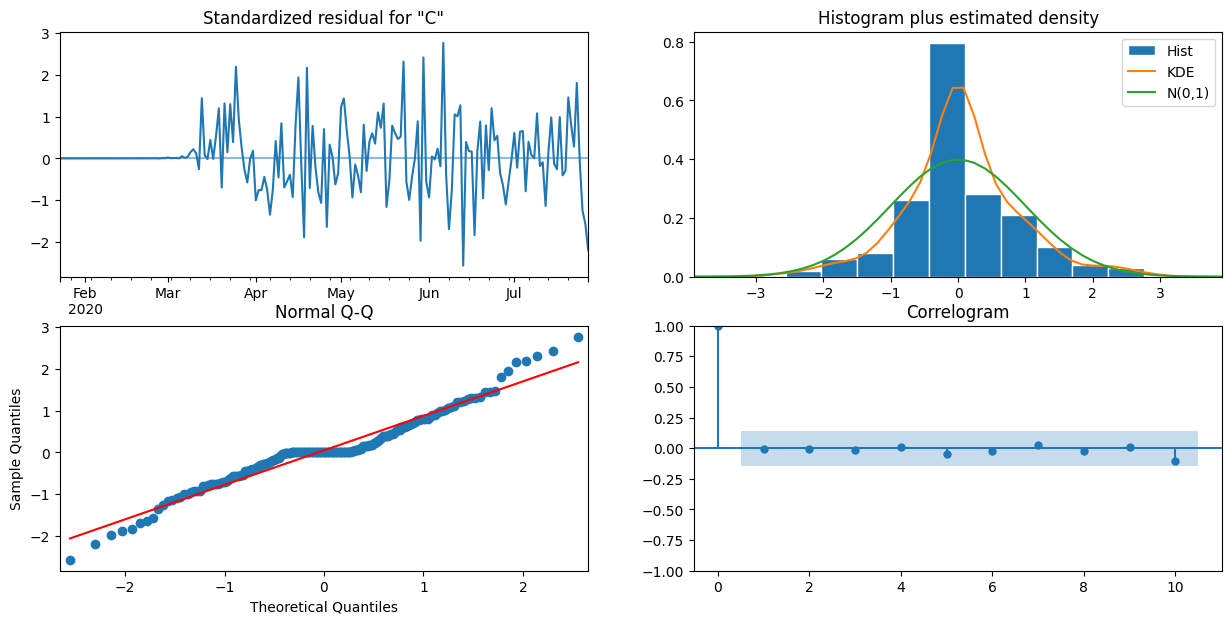

In [9]:
X = full_serie.groupby('Date').Confirmed.sum().copy()

# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(X)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


# SARIMA Model
best_model = SARIMAX(X,order=(6,1,1),seasonal_order=(2,0,[1,2],7)).fit(dis=1)
print(best_model.summary()) # .tables[1]
best_model.plot_diagnostics(figsize=(15,7))
plt.show()

## SARIMAX (ajustado)

### Class Modelo_SARIMAX

In [10]:
class Modelo_SARIMAX():
    def __init__(self, serie, coluna):
        self.serie = serie
        self.coluna = coluna


    def autoarima_e_treino(self):
        
        # auto_arima
        X = self.serie.groupby('Date')[self.coluna].sum().copy()
        
        auto_arima(X,seasonal=True,m=7)
        stepwise_fit = auto_arima(X, start_p=0, start_q=0, 
                                    max_p=6, max_q=3, m=7,
                                    seasonal=True,
                                    trace=False, # True caso queira observar os valores de cada fit
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)
        results = [ stepwise_fit.get_params()['order'], 
                    stepwise_fit.get_params()['seasonal_order']]

        # Treinamento
        cut = int(X.shape[0] * 0.80)
        self.train = X.iloc[:cut]
        self.test = X.iloc[cut:]

        start = self.train.shape[0]
        end   = X.shape[0] - 1

        model = SARIMAX(self.train, 
                        order=results[0],
                        seasonal_order=results[1]).fit(dis=1)

        self.pred = model.predict(  start=start,
                                    end=end,
                                    dynamic=False,
                                    typ='levels')
        
        self.pred.index = self.test.index


    def metricas(self):
        print(f"R²   ---  {r2_score(self.test, self.pred):.2f}")
        print(f"MAE  ---  {mean_absolute_error(self.test, self.pred):.2f}")
        print(f"RMSE ---  {mean_squared_error(self.test, self.pred, squared=False):.2f}")
        print(f"MAPE ---  {mean_absolute_percentage_error(self.test, self.pred)}")


    def graficos(self):
        fig, axs = plt.subplots(2, 1, figsize=(14, 4), constrained_layout=True)

        ax = axs[0]
        ax.set_title(f'Predição para o Nº de {self.coluna[0]}')
        ax.plot(self.test, label='Test') # color='orange'
        ax.plot(self.pred, label='Prediction') # color='green'
        ax.legend(loc='best')

        ax = axs[1]
        ax.set_title(f'Predição para o Nº de {self.coluna[0]}')
        ax.plot(self.train, label='Train')
        ax.plot(self.test, label='Test')
        ax.plot(self.pred, label='Prediction')
        ax.legend(loc='best')

        plt.show()

### Analisando predição de confirmados

In [11]:
pred_confirmed_1 = Modelo_SARIMAX(  serie = full_serie,
                                    coluna = ['Confirmed'])

pred_confirmed_1.autoarima_e_treino()
pred_confirmed_1.metricas()


R²   ---  0.98
MAE  ---  16763.64
RMSE ---  23619.03
MAPE ---  0.014941680144294204


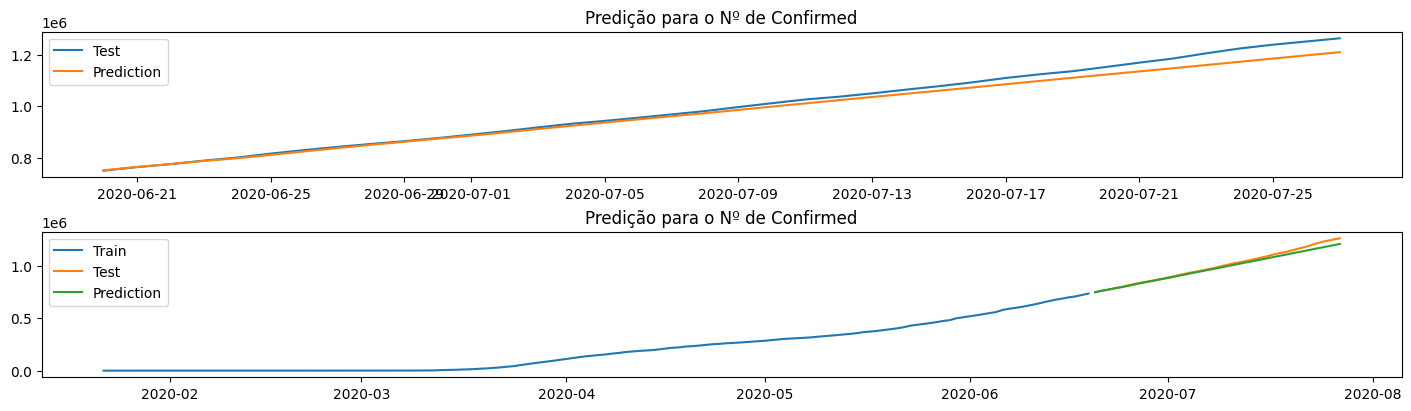

In [12]:
pred_confirmed_1.graficos()

É possivel notar mais uma melhora consideral nos resultados da analise das predições do numero de confirmados, saindo de um R² 0.92 para R² 0.98, além de um MAPE também menor.

### Analisando predição dos obitos

In [13]:
pred_deaths_1 = Modelo_SARIMAX(  serie = full_serie,
                                    coluna = ['Deaths'])

pred_deaths_1.autoarima_e_treino()
pred_deaths_1.metricas()

R²   ---  -0.91
MAE  ---  10949.68
RMSE ---  12778.26
MAPE ---  0.1375723009833041


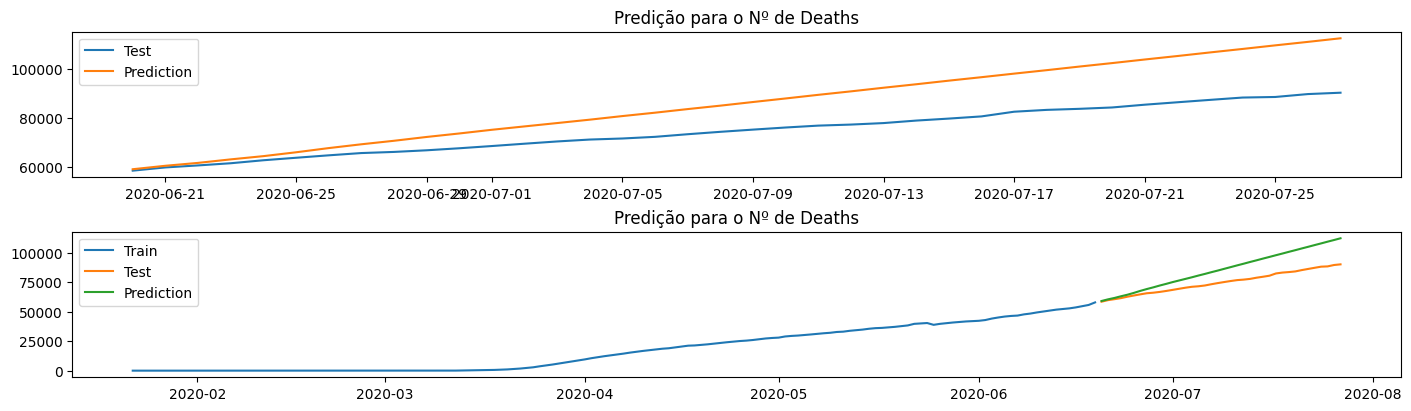

In [14]:
pred_deaths_1.graficos()

O resultado negativo do R² (-0.91) indica que as variaveis estão correlacionadas negativamente, e por está muito proximo de -1,0 essa associação pode ser considerada uma associação negativamente forte.

Podemos interpretar esse resultado da seguintemente maneira: o modelo preditivo está indicando que ao passar do tempo o numero de mortes tende a aumentar.

### Sobre as metricas

Erro Médio Absoluto (MAE), que é a média dos erros absolutos (ignorando o sinal positivo ou negativo). Assim sabemos melhor quanto estamos desviando dos valores reais nas unidades originais.

Erro Percentual Absoluto Médio (MAPE). É uma métrica bastante utilizada na área de previsões de séries temporais, e se refere à média do percentual de erros cometidos nas previsões, desconsiderando a direção (acima ou abaixo do real).

## Analisando países individualmente

### Argentina

In [15]:
pred_arg_confirmed = Modelo_SARIMAX(  serie = argentina,
                                    coluna = ['Confirmed'])

pred_arg_confirmed.autoarima_e_treino()
pred_arg_confirmed.metricas()

R²   ---  0.73
MAE  ---  13441.84
RMSE ---  19225.41
MAPE ---  0.11000709810415377


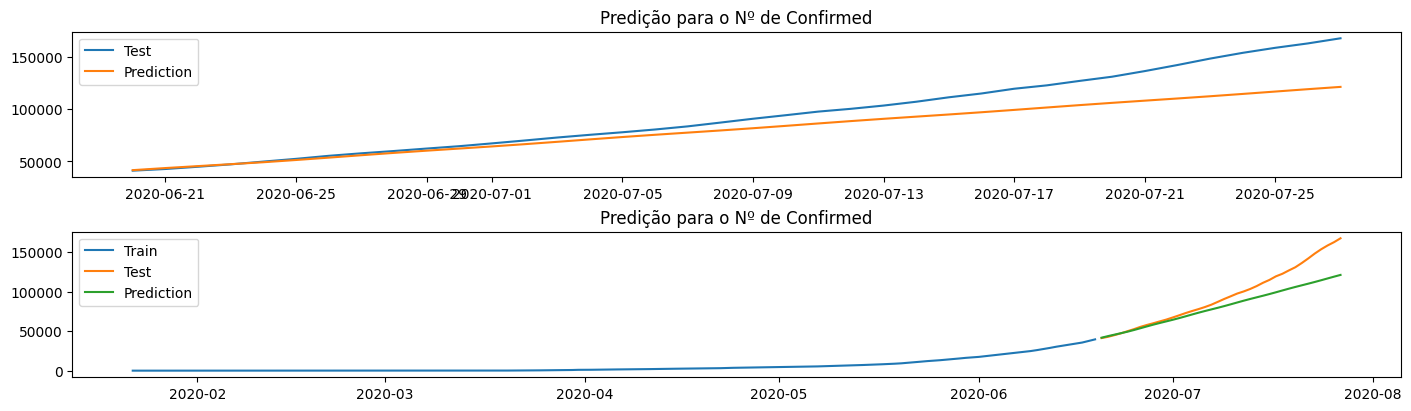

In [16]:
pred_arg_confirmed.graficos()

In [17]:
import csv

In [18]:
# pred_arg = pred_arg_confirmed.test.copy()
# pred_arg['pred'] = pred_arg_confirmed.pred.copy()
# pred_arg.to_csv('pred_arg.csv')

Usar argentina

### Chile

In [19]:
pred_chi_confirmed = Modelo_SARIMAX(  serie = chile,
                                    coluna = ['Confirmed'])

pred_chi_confirmed.autoarima_e_treino()
pred_chi_confirmed.metricas()

R²   ---  0.33
MAE  ---  23185.87
RMSE ---  26318.51
MAPE ---  0.07340878153168193


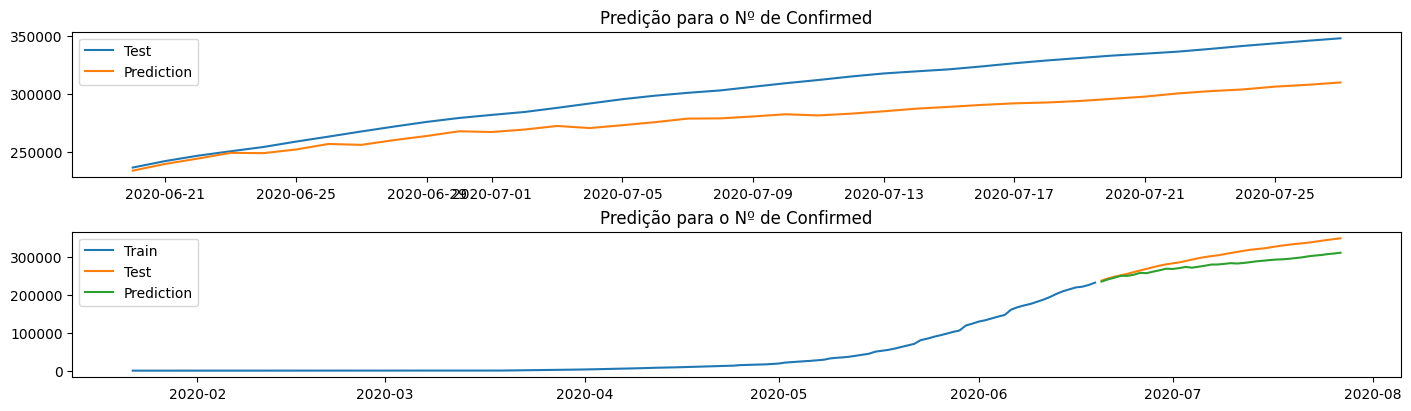

In [20]:
pred_chi_confirmed.graficos()

### Equador

In [21]:
pred_equa_confirmed = Modelo_SARIMAX(  serie = equador,
                                    coluna = ['Confirmed'])

pred_equa_confirmed.autoarima_e_treino()
pred_equa_confirmed.metricas()

R²   ---  0.61
MAE  ---  4811.19
RMSE ---  6043.72
MAPE ---  0.06743232709198481


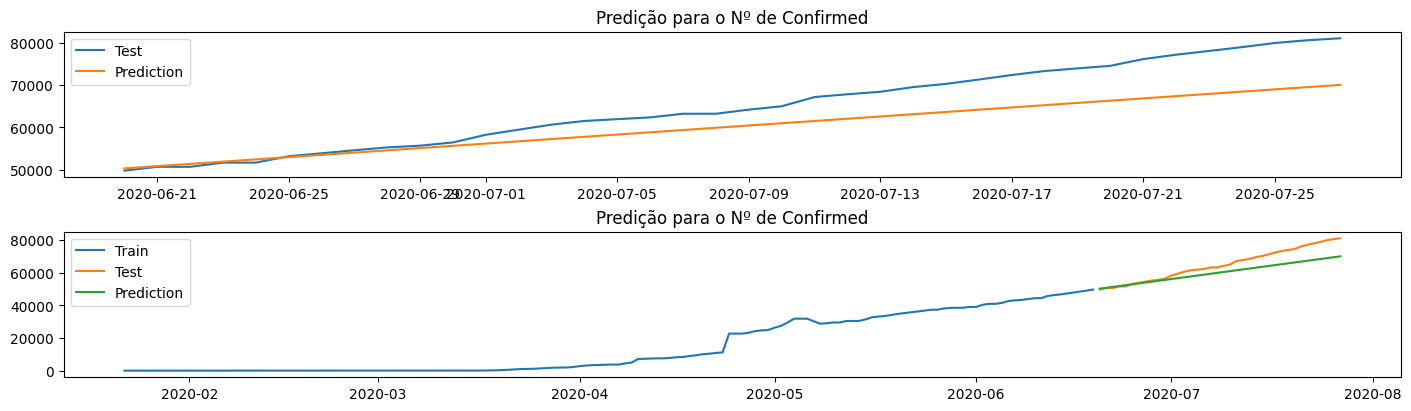

In [22]:
pred_equa_confirmed.graficos()

### Mexico

In [23]:
pred_mex_confirmed = Modelo_SARIMAX(  serie = mexico,
                                    coluna = ['Confirmed'])

pred_mex_confirmed.autoarima_e_treino()
pred_mex_confirmed.metricas()

R²   ---  0.99
MAE  ---  6410.04
RMSE ---  7491.77
MAPE ---  0.020848506097742536


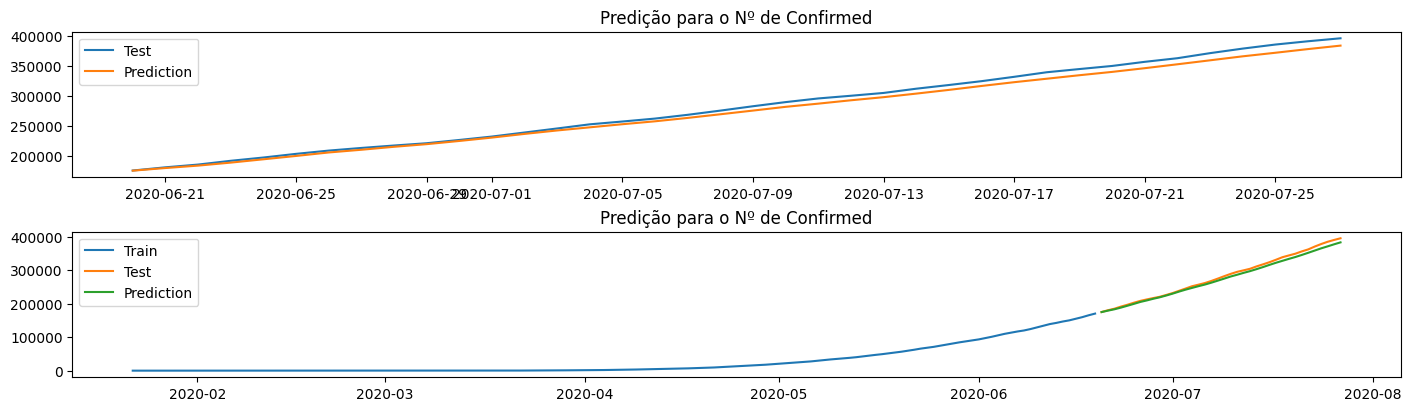

In [24]:
pred_mex_confirmed.graficos()

Usar mexico

In [25]:
# pred_mex = pred_mex_confirmed.test.copy()
# pred_mex['pred'] = pred_mex_confirmed.pred.copy()
# pred_mex.to_csv('pred_mex.csv')

### Espanha

In [26]:
pred_esp_confirmed = Modelo_SARIMAX(  serie = espanha,
                                    coluna = ['Confirmed'])

pred_esp_confirmed.autoarima_e_treino()
pred_esp_confirmed.metricas()

R²   ---  0.62
MAE  ---  2985.32
RMSE ---  5187.76
MAPE ---  0.011192836481776984


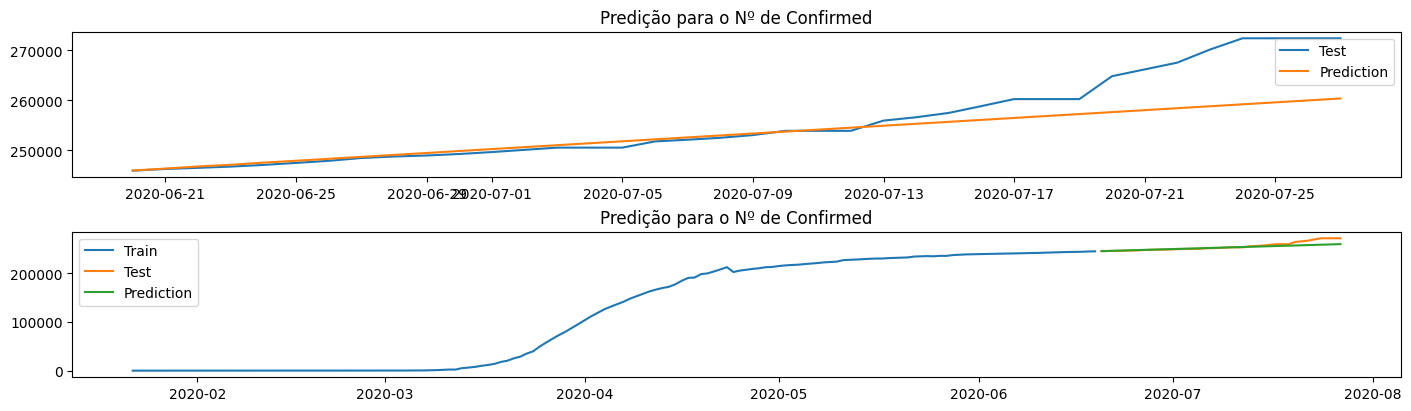

In [27]:
pred_esp_confirmed.graficos()

Essa subida repentida pode representar o inicio da segunda onda

In [28]:
pred_esp = pred_esp_confirmed.test.copy()
pred_esp['pred'] = pred_esp_confirmed.pred.copy()
pred_esp.to_csv('pred_esp.csv')

## Predição com analise de sentimento

In [29]:
df_sentimento = pd.read_csv('https://raw.githubusercontent.com/AugustoCRX/bootcamp_covid/main/notebooks/data/df_analise')


HTTPError: HTTP Error 404: Not Found

In [ ]:
df_sentimento

,text,score,retweet,like,date,lat,long,país,prediction
0,"['oms', 'estima', 'habra', 'vacuna', 'coronavi...",0.0,0,1,2020-02-11,-34.604450,-58.446244,argentina,1
1,"['coronavirus', 'covid', '19', 'enfermedad', '...",0.0,0,0,2020-02-11,-34.604450,-58.446244,argentina,0
2,"['digas', 'virus', 'chino', 'enfermedad', 'chi...",0.0,0,0,2020-02-11,-34.604450,-58.446244,argentina,0
3,"['coronavirus', 'covid', '19', 'paciente', 'co...",0.0,0,2,2020-02-12,-32.951572,-60.693506,argentina,1
4,"['coronavirus', 'covid', '19', 'paciente', 'co...",0.0,1,1,2020-02-12,-32.951572,-60.693506,argentina,1
...,...,...,...,...,...,...,...,...,...
71121,"['rusia', 'podria', 'aprobar', 'vacuna', 'covi...",0.0,0,0,2020-07-30,NaN,NaN,mexico,1
71122,"['goberladrones', 'oposicion', 'alteran', 'mue...",0.0,1,0,2020-07-30,NaN,NaN,mexico,1
71123,"['mexico', 'to', 'test', ""sanofi-pasteur's"", '...",0.0,0,0,2020-07-30,NaN,NaN,mexico,0
71124,"['coludos', 'rabones', '#porlomenos', '#todosj...",0.0,0,0,2020-07-30,NaN,NaN,mexico,1


### Criando series

In [ ]:
def criar_serie_sentimento(df, nome_pais):

    filtro = df[df['país'] == nome_pais]
    pais = filtro.groupby('date')[['date', 'prediction']].sum()
    
    #pd.to_datetime(pais.date)
    #pais.set_index('date', inplace=True)
    
    return pais

In [ ]:
argentina_sent = criar_serie_sentimento(df_sentimento, 'argentina')
chile_sent = criar_serie_sentimento(df_sentimento, 'chile')
equador_sent = criar_serie_sentimento(df_sentimento, 'ecuador')
# mexico = criar_serie(df, 'Mexico')
# espanha = criar_serie(df, 'Spain')

# full_serie = criar_serie(df, df['Country/Region'])

## Analisando predição das analises de sentimento

### Classe

In [ ]:
class Modelo_SARIMAX_sentimento():
    def __init__(self, serie, coluna):
        self.serie = serie
        self.coluna = coluna


    def autoarima_e_treino(self):
        
        # auto_arima
        #X = self.serie.groupby('date')[self.coluna].sum().copy()
        X = self.serie
        
        auto_arima(X,seasonal=True,m=7)
        stepwise_fit = auto_arima(X, start_p=0, start_q=0, 
                                    max_p=6, max_q=3, m=7,
                                    seasonal=True,
                                    trace=False, # True caso queira observar os valores de cada fit
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)
        results = [ stepwise_fit.get_params()['order'], 
                    stepwise_fit.get_params()['seasonal_order']]

        # Treinamento
        cut = int(X.shape[0] * 0.80)
        self.train = X.iloc[:cut]
        self.test = X.iloc[cut:]

        start = self.train.shape[0]
        end   = X.shape[0] - 1

        model = SARIMAX(self.train, 
                        order=results[0],
                        seasonal_order=results[1]).fit(dis=1)

        self.pred = model.predict(  start=start,
                                    end=end,
                                    dynamic=False,
                                    typ='levels')
        
        self.pred.index = self.test.index


    def metricas(self):
        print(f"R²   ---  {r2_score(self.test, self.pred):.2f}")
        print(f"MAE  ---  {mean_absolute_error(self.test, self.pred):.2f}")
        print(f"RMSE ---  {mean_squared_error(self.test, self.pred, squared=False):.2f}")
        print(f"MAPE ---  {mean_absolute_percentage_error(self.test, self.pred)}")


    def graficos(self):
        fig, axs = plt.subplots(2, 1, figsize=(15, 6), constrained_layout=True)

        ax = axs[0]
        ax.set_title(f'Predição para o Nº de {self.coluna[0]}')
        ax.plot(self.test, label='Test') # color='orange'
        ax.plot(self.pred, label='Prediction') # color='green'
        ax.legend(loc='best')

        ax = axs[1]
        ax.set_title(f'Predição para o Nº de {self.coluna[0]}')
        ax.plot(self.train, label='Train')
        ax.plot(self.test, label='Test')
        ax.plot(self.pred, label='Prediction')
        ax.legend(loc='best')

        plt.show()

### Argentina

In [ ]:
def criar_serie_sentimento_2(df, nome_pais, sentimento):

    filtro = df[df['país'] == nome_pais]
    filtro_sentimento = filtro[filtro['prediction'] == sentimento]
    # pais = filtro_sentimento.date.value_counts(sort=False)
    pais = filtro_sentimento.groupby('date')[['date', 'prediction']].sum()
    
    pais['date'] = pd.to_datetime(pais.index)
    pais.set_index('date', inplace=True)
    
    return pais

In [ ]:
argentina_sent_positivo = criar_serie_sentimento_2(df_sentimento, 'argentina', 1)
argentina_sent_negativo = criar_serie_sentimento_2(df_sentimento, 'argentina', 0)

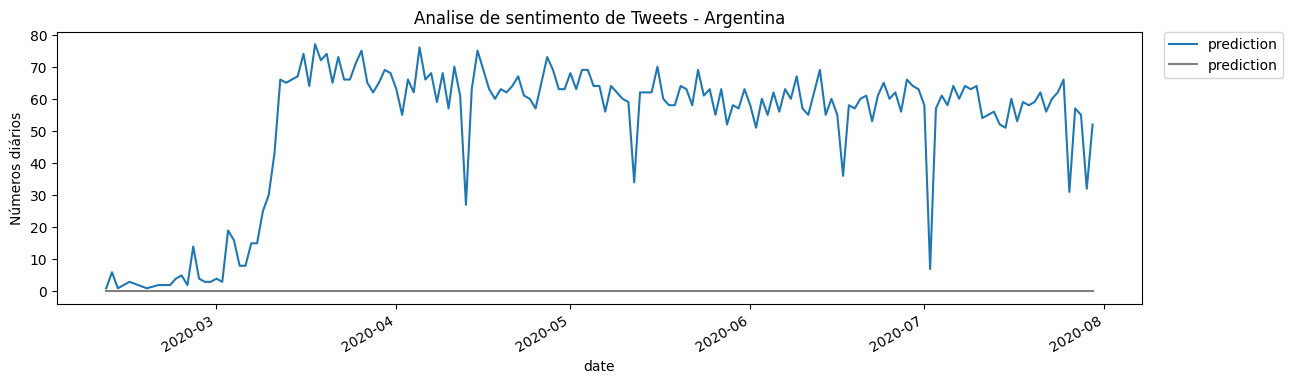

In [ ]:
fig, ax = plt.subplots(figsize=(14,4))
argentina_sent_positivo.plot(ax=ax, legend=True, label= 'positivos')
argentina_sent_negativo.plot(ax=ax, legend=True,label = 'negativos', color='gray')

ax.set_title(r'Analise de sentimento de Tweets - Argentina')
ax.set_ylabel(r'Números diários')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

In [ ]:
pred_arg_sentimento = Modelo_SARIMAX_sentimento(  serie = argentina_sent_positivo,
                                                    coluna = argentina_sent_positivo.values)

pred_arg_sentimento.autoarima_e_treino()
pred_arg_sentimento.metricas()

R²   ---  -0.26
MAE  ---  7.14
RMSE ---  12.78
MAPE ---  0.35244117386229845


In [ ]:
pred_arg_sentimento = Modelo_SARIMAX_sentimento(  serie = argentina_sent_negativo,
                                                    coluna = argentina_sent_negativo.values)

pred_arg_sentimento.autoarima_e_treino()
pred_arg_sentimento.metricas()

R²   ---  1.00
MAE  ---  0.00
RMSE ---  0.00
MAPE ---  0.0


In [ ]:
pred_arg_sentimento = Modelo_SARIMAX_sentimento(  serie = teste_2,
                                    coluna = ['prediction'])

pred_arg_sentimento.autoarima_e_treino()
pred_arg_sentimento.metricas()

NameError: name 'teste_2' is not defined

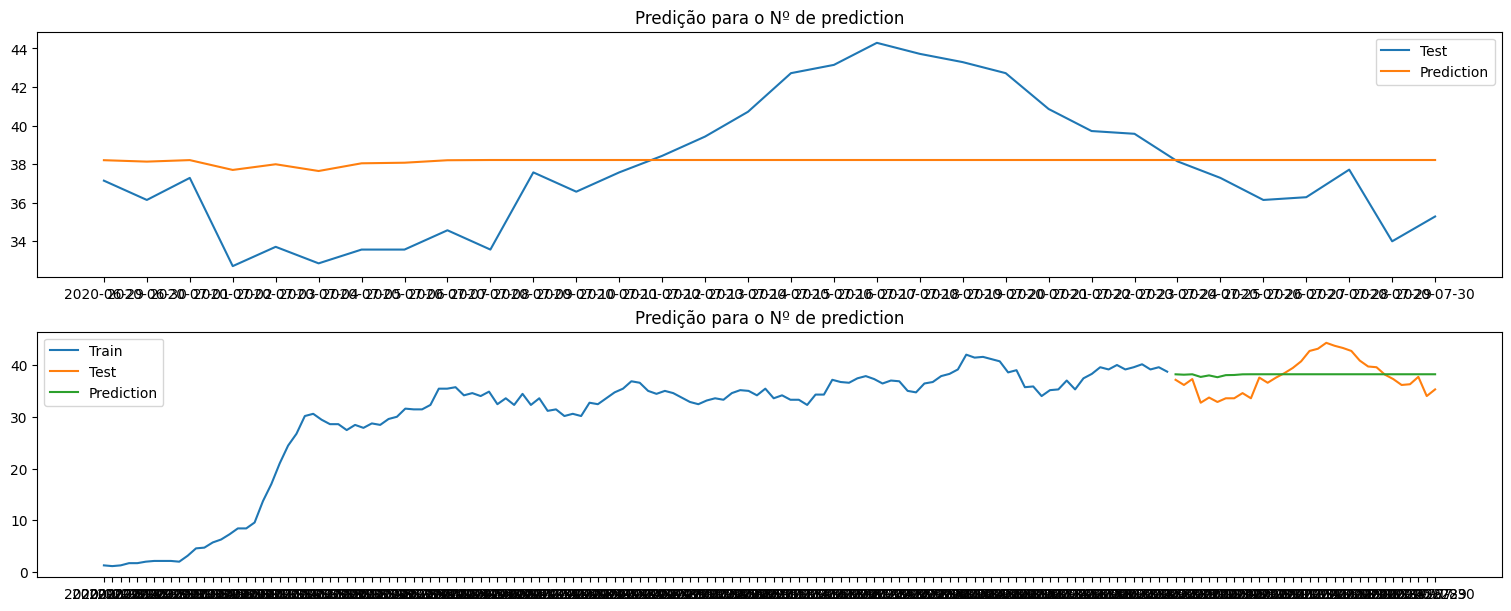

In [ ]:
pred_arg_sentimento.graficos()

In [ ]:
teste = argentina_sent.rolling(7).mean().dropna()

<AxesSubplot: xlabel='date'>

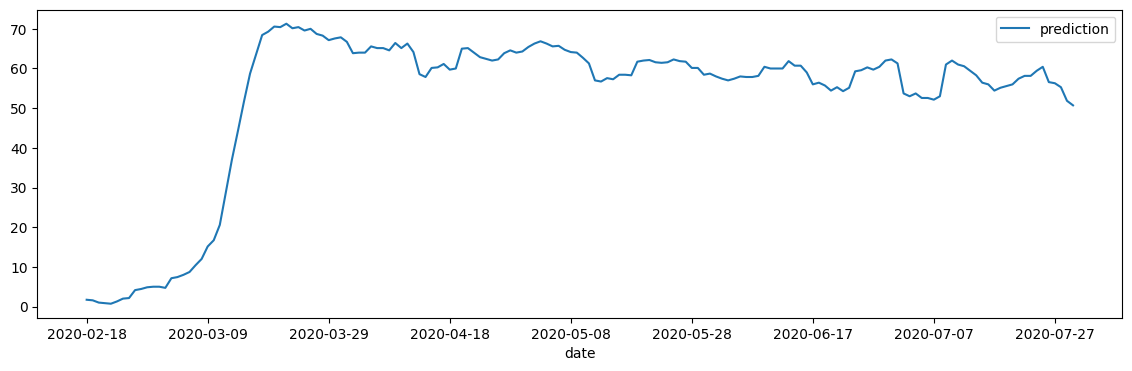

In [ ]:
teste.plot(figsize=(14,4))

In [ ]:
pred_arg_sentimento = Modelo_SARIMAX_sentimento(  serie = teste,
                                    coluna = ['prediction'])

pred_arg_sentimento.autoarima_e_treino()
pred_arg_sentimento.metricas()

R²   ---  -6.74
MAE  ---  8.12
RMSE ---  9.45
MAPE ---  0.14693831682453304


In [ ]:
pred_arg_sentimento = Modelo_SARIMAX_sentimento(  serie = argentina_sent,
                                    coluna = ['prediction'])

pred_arg_sentimento.autoarima_e_treino()
pred_arg_sentimento.metricas()

R²   ---  -0.26
MAE  ---  7.14
RMSE ---  12.79
MAPE ---  0.3524501969739914


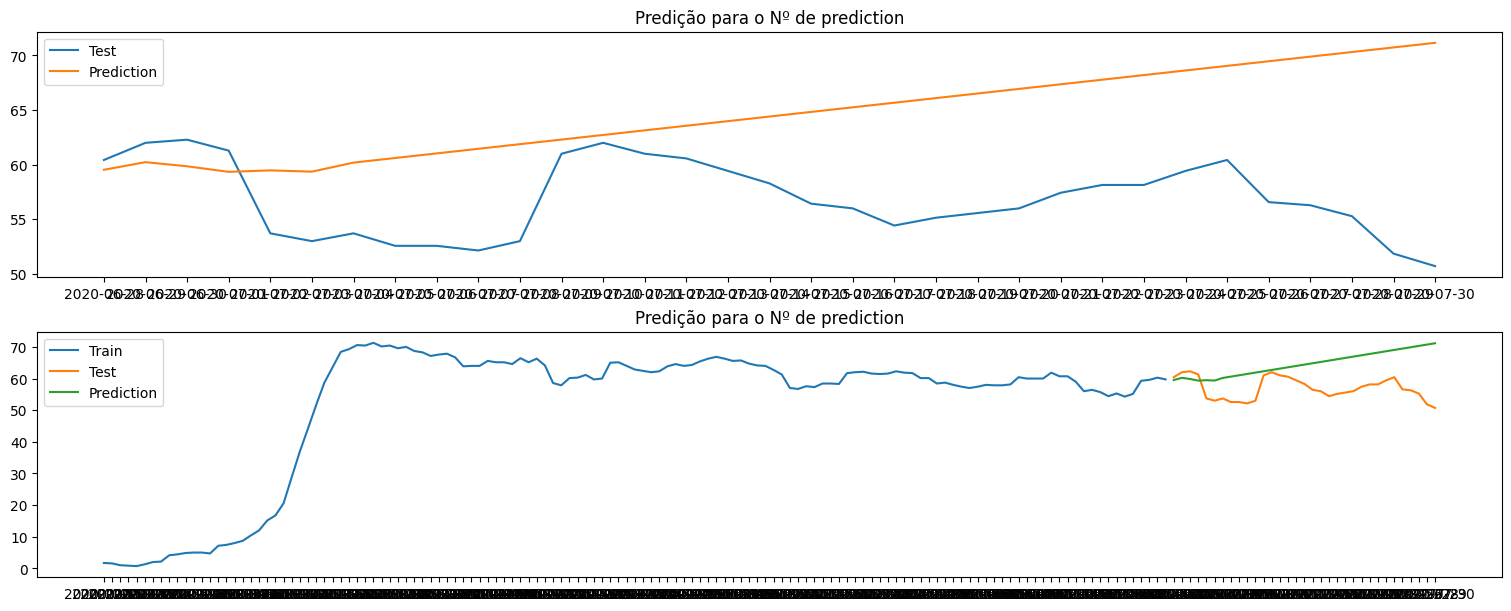

In [ ]:
pred_arg_sentimento.graficos()

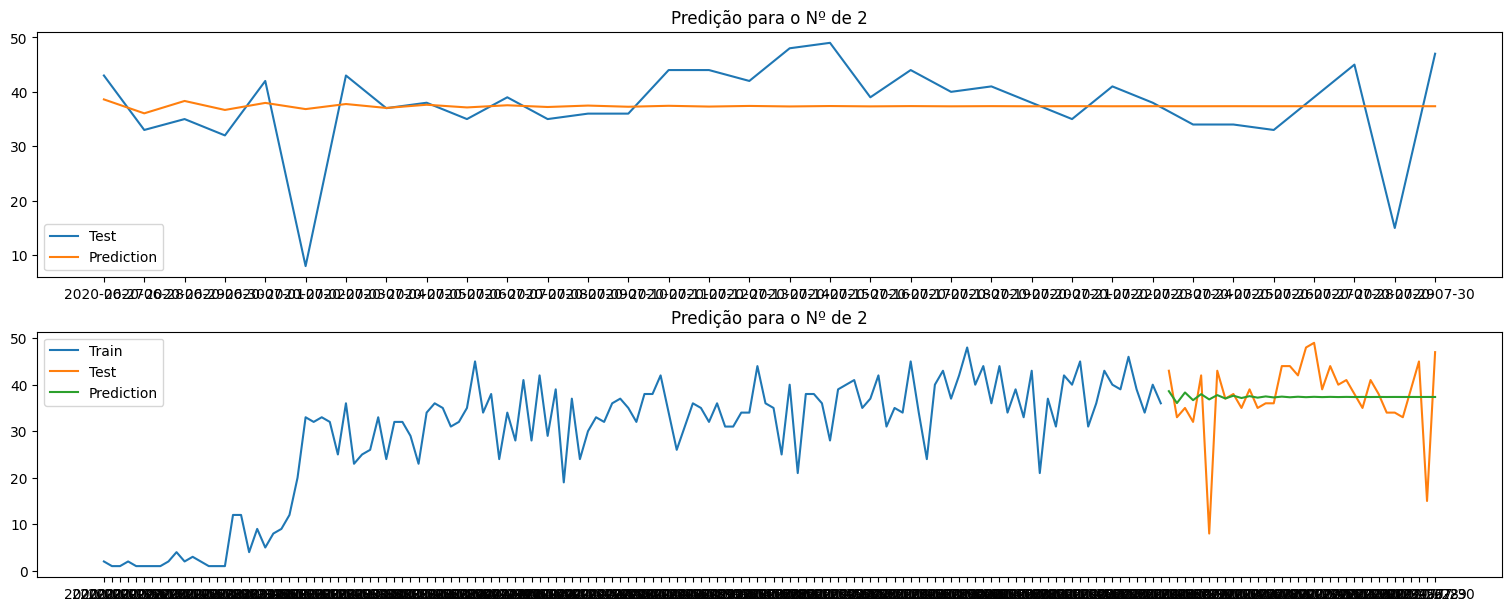

In [ ]:
pred_arg_sentimento.graficos()

### Chile

In [ ]:
pred_chi_sentimento = Modelo_SARIMAX_sentimento(  serie = chile_sent,
                                    coluna = ['prediction'])

pred_chi_sentimento.autoarima_e_treino()
pred_chi_sentimento.metricas()

R²   ---  -0.02
MAE  ---  6.51
RMSE ---  8.76
MAPE ---  0.1292641526797788


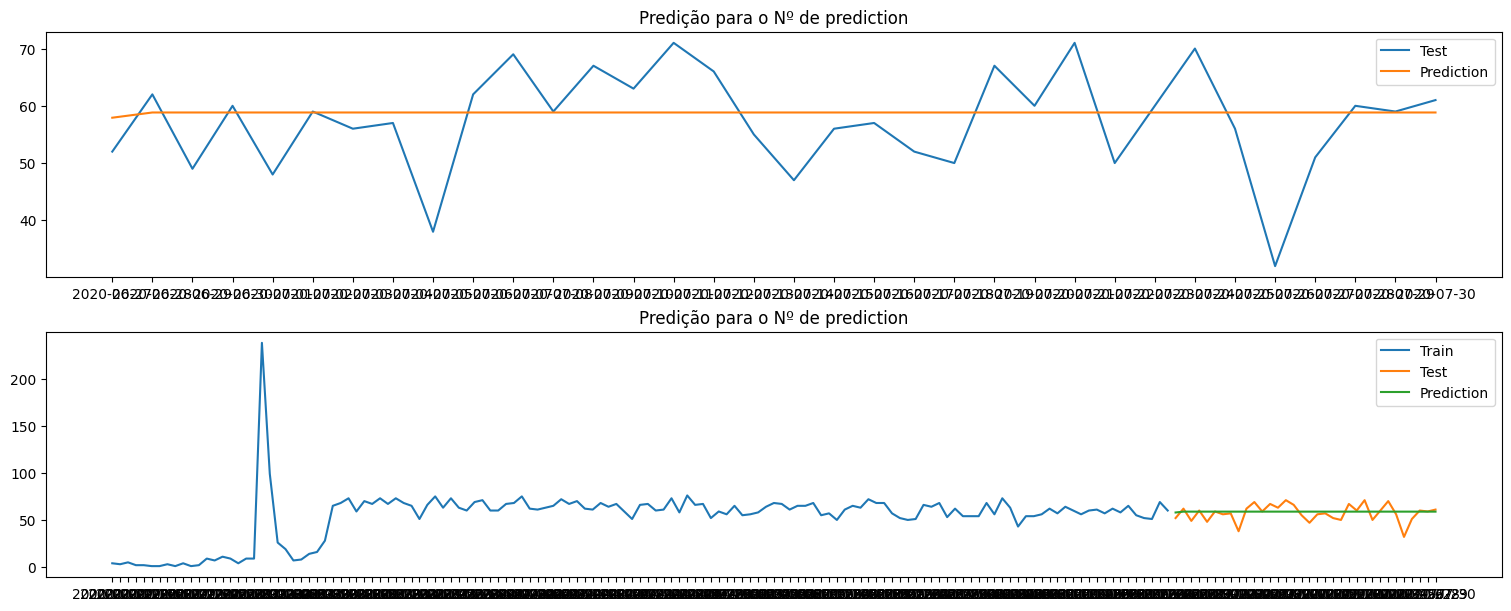

In [ ]:
pred_chi_sentimento.graficos()